In [35]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns
import xarray as xr
#import palettes

In [36]:
# Load output
spec_febTS = xr.open_dataset('../curtain_SSH_spectra_febTS.nc')
X_spec = spec_febTS.X

ssh_febTS = xr.open_dataset('../curtain_SSH_SVB_febTS.nc')
ssh_febTS_NoB = xr.open_dataset('../curtain_SSH_NoSVB_febTS.nc')
X_ssh = ssh_febTS.X

spec_baro = xr.open_dataset('../curtain_SSH_spectra_barotropic.nc')
X = spec_baro.X

ssh_baro = xr.open_dataset('../curtain_SSH_SVB_Barotropic.nc')
ssh_baro_NoB = xr.open_dataset('../curtain_SSH_NoSVB_Barotropic.nc')

In [37]:
# Get coastline points
df = pd.read_csv('../coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [38]:
# Load grid variables and mask
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

nx = len(lon)
ny = len(lat)
nt = 720
# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
depth = ds['Depth'][:]

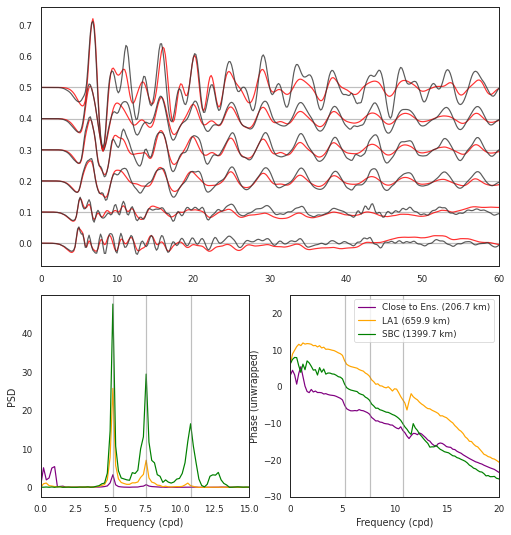

In [39]:
sns.set_context('paper')
sns.set_style('white')

time = np.arange(0,720)*600
colors = ['purple', 'orange','green']

fig = plt.figure(figsize=(7.48,8))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05,bottom=0.5, top=0.95, wspace=0.05, hspace=0.15)
ax1 = plt.subplot(gs1[0,0])
offset=0

gs2 = gridspec.GridSpec(1, 2, wspace=0.2)
gs2.update(left=0.05,bottom=0.1, top=0.45, hspace=0.05)
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs2[0,1])

for kk, col, lab in zip([100, 307, 440],colors, ['Close to Ens.','LA1','SBC']):
    ax2.plot(spec_febTS.Freq, spec_febTS.psd_data[kk,:],color=col, 
             label='%s, (%1.1f km)' %(lab,X[kk]))
    ax3.plot(spec_febTS.Freq, np.unwrap(spec_febTS.phase_data[kk,:]),
             color=col,label='%s (%1.1f km)' %(lab,X[kk]))
ax2.axvline(5.2, color='0.5', alpha=0.5)     
ax3.axvline(5.2, color='0.5', alpha=0.5)     
ax2.axvline(7.6, color='0.5', alpha=0.5)     
ax3.axvline(7.6, color='0.5', alpha=0.5)     
ax2.axvline(10.8, color='0.5', alpha=0.5)     
ax3.axvline(10.8, color='0.5', alpha=0.5)     

ax3.legend(ncol=1)
ax2.set_xlim(0,15)
ax3.set_ylim(-30,25)
ax3.set_xlim(0,20)
ax2.set_xlabel('Frequency (cpd)')
ax3.set_xlabel('Frequency (cpd)')
ax2.set_ylabel('PSD')
ax3.set_ylabel('Phase (unwrapped)')

for kk, lab in zip([47,100,230,307,335,440], 
                   ['San Quintín', 'Close to Ensenada','San Diego','LA1','LA2','SBC']):
    eta = 100*(ssh_febTS.curtain_data[:,kk]-ssh_febTS_NoB.curtain_data[:,kk])+offset
    etab = 100*(ssh_baro.curtain_data[:,kk]-ssh_baro_NoB.curtain_data[:,kk])+offset
    ax1.axhline(offset, color='0.5', alpha=0.5)
    ax1.plot(ssh_febTS.T/3600,eta, label=lab , alpha=0.8, color='red')
    ax1.plot(ssh_baro.T/3600,etab, label=lab , alpha=0.8, color='0.2')
    offset = offset + 0.1
ax1.set_xlim(0,24*2.5)
  
# --------------------------------


plt.savefig('figure4.png', dpi=500, bbox_inches='tight')

In [40]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()
view raw


<xarray.Dataset>
Dimensions:       (t: 720, x: 555)
Dimensions without coordinates: t, x
Data variables:
    X             (x) float64 ...
    T             (t) float64 0.0 600.0 1.2e+03 ... 4.308e+05 4.314e+05
    curtain_data  (t, x) float64 ...
Attributes:
    title:        SSH curtain plot data barotropic SVB
    author:       Karina Ramos Musalem
    institution:  ICACC-UNAM
    source:       /notebooks/MITgcm/domain5/ssh_hovmoller_at_coast_all_points...
    description:  SSH data at points along the coast to build curtain hovmöll...
    timeStamp:    Sun Dec  5 10:50:37 2021